# Real-world example - Analysis of scDVP liver zonation dataset

In this example we showcase how spatialdata can be leveraged in the analysis of real-world DVP data. For this purpose we utilize a small subset of the previously published dataset by {cite:p}`Rosenberger2023` [(Rosenberger et al, 2023)](https://doi.org/10.1038/s41592-023-02007-6), specifically the sample `m1a`. This datasets originally includes

- IF images (as `.tiff`) of the mouse liver, including the markers Glutamine Synthethase, E-Cadherin, cell membrane marker (WGA), and phalloidin (cytoskeleton)

- Cell segmentation shapes of the profiled cells as LMD-compatible `.xml` file

- Proteomics measurements of 77 single shapes as DIANN protein groups report (`.tsv`)


We generated a single data container of this data in this [tutorial](https://dvp-io.readthedocs.io/en/latest/tutorials/004_scdvp.html). We will now check out how we can use `spatialdata` to jointly store and visualize these different modalities.

## Packages

Run this command if you still need to create an environment

In [1]:
# ! pip install "spatialdata[extra]" xarray numba jupyter

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spatialdata as sd
import spatialdata_plot  # noqa
from napari_spatialdata import Interactive

/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Get data

In [5]:
%%bash
downloadpath="./scdvp"
mkdir -p $downloadpath
wget -O $downloadpath/scdvp.rosenberger2023.sdata.zarr.zip  "https://datashare.biochem.mpg.de/s/9LKUTJYcyizHmaZ/download"
unzip -d $downloadpath/ $downloadpath/scdvp.rosenberger2023.sdata.zarr.zip
rm $downloadpath/scdvp.rosenberger2023.sdata.zarr.zip

--2025-05-26 09:32:06--  https://datashare.biochem.mpg.de/s/9LKUTJYcyizHmaZ/download
Resolving datashare.biochem.mpg.de (datashare.biochem.mpg.de)... 130.183.207.23
Connecting to datashare.biochem.mpg.de (datashare.biochem.mpg.de)|130.183.207.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18216891 (17M) [application/zip]
Saving to: ‘./scdvp/scdvp.rosenberger2023.sdata.zarr.zip’

     0K .......... .......... .......... .......... ..........  0%  663K 27s
    50K .......... .......... .......... .......... ..........  0% 1.24M 20s
   100K .......... .......... .......... .......... ..........  0% 12.4M 14s
   150K .......... .......... .......... .......... ..........  1% 1.29M 14s
   200K .......... .......... .......... .......... ..........  1% 35.5M 11s
   250K .......... .......... .......... .......... ..........  1% 10.6M 9s
   300K .......... .......... .......... .......... ..........  1% 3.81M 9s
   350K .......... .......... .......... ..........

Archive:  ./scdvp/scdvp.rosenberger2023.sdata.zarr.zip
   creating: /Users/lucas-diedrich/Documents/Lab/teaching/Workshops/Group Retreat 2025 - Learn Session - Spatialdata/notebooks/scdvp/rosenberger2023.subset.sdata.zarr
  inflating: ./scdvp//__MACOSX/._rosenberger2023.subset.sdata.zarr  
   creating: /Users/lucas-diedrich/Documents/Lab/teaching/Workshops/Group Retreat 2025 - Learn Session - Spatialdata/notebooks/scdvp/rosenberger2023.subset.sdata.zarr/tables
  inflating: ./scdvp//__MACOSX/rosenberger2023.subset.sdata.zarr/._tables  
  inflating: ./scdvp//rosenberger2023.subset.sdata.zarr/.zattrs  
  inflating: ./scdvp//__MACOSX/rosenberger2023.subset.sdata.zarr/._.zattrs  
   creating: /Users/lucas-diedrich/Documents/Lab/teaching/Workshops/Group Retreat 2025 - Learn Session - Spatialdata/notebooks/scdvp/rosenberger2023.subset.sdata.zarr/images
  inflating: ./scdvp//__MACOSX/rosenberger2023.subset.sdata.zarr/._images  
  inflating: ./scdvp//rosenberger2023.subset.sdata.zarr/.zgroup  


## Create spatialdata object

We will successively add attributes to our spatialdata object. Let's initialize an empty object:

In [8]:
# Initialize an empty spatialdata object
sdata = sd.read_zarr("./scdvp/rosenberger2023.subset.sdata.zarr")
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/lucas-diedrich/Documents/Lab/teaching/Workshops/Group Retreat 2025 - Learn Session - Spatialdata/notebooks/scdvp/rosenberger2023.subset.sdata.zarr
├── Images
│     └── 'm1a_image': DataArray[cyx] (4, 2000, 2000)
├── Shapes
│     └── 'cell_segmentation': GeoDataFrame shape: (10, 3) (2D shapes)
└── Tables
      └── 'm1a_table': AnnData (4, 3738)
with coordinate systems:
    ▸ 'global', with elements:
        m1a_image (Images), cell_segmentation (Shapes)
    ▸ 'to_lmd', with elements:
        cell_segmentation (Shapes)

## Interact with spatialdata

Let's access the raw image. This works similarly to a dictionary lookup. We see that it is an `xarray.DataArray` under the hood. `xarray` nicely visualizes the overall shape of the image.

### Images

In [9]:
sdata.images["m1a_image"]

<xarray.DataArray 'image' (c: 4, y: 2000, x: 2000)> Size: 32MB
dask.array<from-zarr, shape=(4, 2000, 2000), dtype=uint16, chunksize=(2, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U10 160B 'GS' 'ECadherin' 'WGA' 'Phalloidin'
  * y        (y) float64 16kB 0.5 1.5 2.5 3.5 ... 1.998e+03 1.998e+03 2e+03
  * x        (x) float64 16kB 0.5 1.5 2.5 3.5 ... 1.998e+03 1.998e+03 2e+03
Attributes:
    transform:  {'global': Sequence \n    Translation (c, y, x)\n        [   ...

Let's also take a look at the single-cell segmentation masks, the shapes. They are stored in a `geopandas.GeoDataFrame`

### Shapes

In [10]:
sdata.shapes["cell_segmentation"]

,name,well,geometry
Shape_41,Shape_41,B19,"POLYGON ((4252.212 7092.576, 4247.196 7100.617..."
Shape_42,Shape_42,B20,"POLYGON ((4196.216 7297.599, 4194.224 7299.591..."
Shape_43,Shape_43,B21,"POLYGON ((4106.21 7532.576, 4105.177 7533.609,..."
Shape_44,Shape_44,B22,"POLYGON ((4424.184 7691.637, 4422.192 7693.629..."
Shape_250,Shape_250,L8,"POLYGON ((5508.027 7895.406, 5506.035 7897.398..."
Shape_251,Shape_251,L9,"POLYGON ((5742.045 8092.388, 5741.012 8093.421..."
Shape_252,Shape_252,L10,"POLYGON ((4934.05 8262.442, 4934.05 8264.434, ..."
Shape_253,Shape_253,L11,"POLYGON ((5063.011 8434.414, 5057.994 8437.438..."
Shape_254,Shape_254,L12,"POLYGON ((5683.983 8605.426, 5679.04 8607.418,..."
Shape_276,Shape_276,M12,"POLYGON ((4702.246 8950.182, 4694.204 8955.198..."


Access a single shape, which are stored as `shapely.Polygon`s

In [11]:
type(sdata.shapes["cell_segmentation"].loc["Shape_41", "geometry"])

shapely.geometry.polygon.Polygon

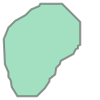

In [12]:
sdata.shapes["cell_segmentation"].loc["Shape_41", "geometry"]

### Transformations

As we can see, the transformation is stored as a matrix

In [ ]:
transformation_shapes = sd.transformations.get_transformation(
    sdata["cell_segmentation"]
)
(
    transformation_shapes,
    transformation_shapes.to_affine(input_axes=("x", "y"), output_axes=("x", "y")),
)

## Plotting

First, we create static plots with `spatialdata-plot`

### Plotting with spatialdata plot

Check out the [documentation](https://spatialdata.scverse.org/projects/plot/en/stable/plotting.html)

Spatialdata plot directly hooks into spatialdata. You can interact with it by adding the `.pl` accessor to a spatialdata object. Depending on the modality, you would like to plot, you need to add `.pl.render_<xxx>`

You can chain an arbitrary number of `render` functions to the object. E.g. you can add shapes/labels if you have image segmentations or shapes available, you can also add them.

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05170319108035372..1.3005151864667437].


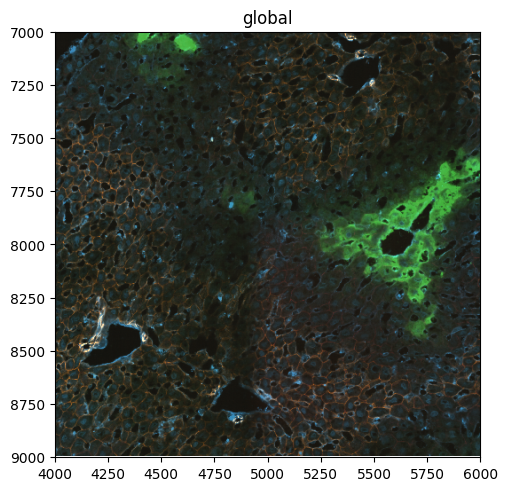

In [13]:
norm = mpl.colors.Normalize(vmin=0, vmax=4000)
(
    sdata
    # Normalize all thress channesl to 0-4000
    .pl.render_images("m1a_image", norm=norm)
    # Specify the coordinate system to show only one
    .pl.show(coordinate_systems="global")
)

## Load shapes

Next, we inspect the shapes.

### Plotting - Overlay of shapes + image
**You should always check/validate whether cell segmentation and image are correctly overlaid.** To do so, we select a small subset of the image and take a look at both cell membrane staining (channel 1) and cell segmentation

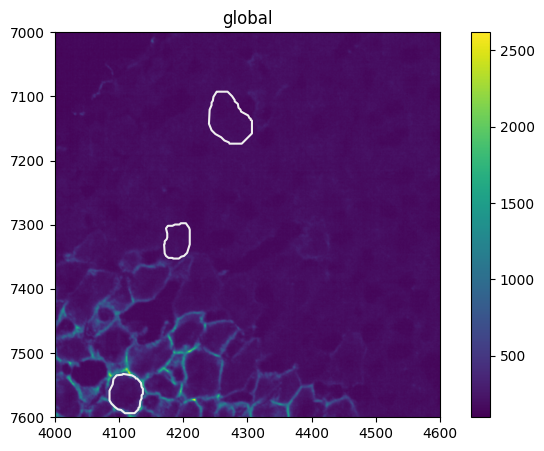

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))


min_coordinate = np.array([4000, 7000])
size = 600
(
    sdata.query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(fill_alpha=0.0, outline_alpha=1, outline_color="#efefef")
    .pl.show(coordinate_systems="global", ax=ax)
)

The overlay between shapes and cell membrane stain looks reasonable.

## Omics data

Now we take a look at the omics data.

### Visualize results
After having added the omics layer to the spatialdata object, **we can overlay the proteomics measurement with the imaging**. In this example, we will focus on E-Cadherin ([P09803](https://www.uniprot.org/uniprotkb/P09803/entry)) for which the original authors also developed an antibody-based staining.

First, we subset the spatialdata object to zoom into an area of interest.

In [ ]:
min_coordinate = np.array([4000, 7000])
size = 600

subset = (
    sdata
    # Subset to relevant area
    # you have to pass the axes, min/max coordinates (in the same format as the axes argument) each and the coordinate system
    .query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
)

/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_segmentation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `m1a_table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_segmentation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `m1a_table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Text(0.5, 1.0, 'Cell segmentation + $\\alpha$-E-Cadherin')

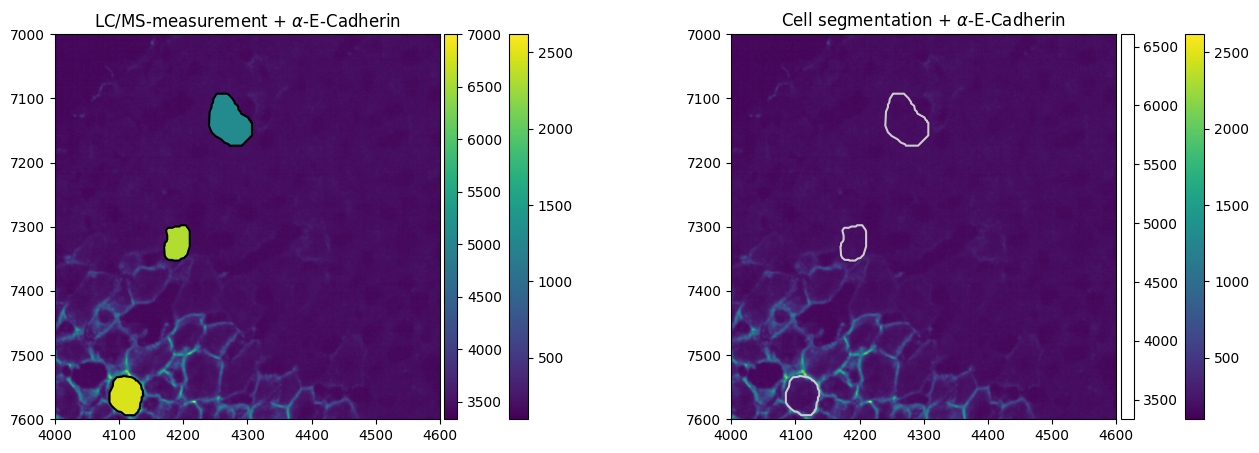

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

(
    subset
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(
        element="cell_segmentation", color="P09803", norm=mpl.colors.Normalize(0, 7000), outline_alpha=1, fill_alpha=1
    )
    .pl.show(coordinate_systems="global", ax=axs[0])
)

# If you pass an axes, you can interact with it similarly to a regular matplotlib.axes.Axes object
axs[0].set_title("LC/MS-measurement + $\\alpha$-E-Cadherin")

(
    subset
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(
        element="cell_segmentation", color="P09803", outline_alpha=1, outline_color="#cccccc", fill_alpha=0
    )
    .pl.show(coordinate_systems="global", ax=axs[1])
)

axs[1].set_title("Cell segmentation + $\\alpha$-E-Cadherin")

We note that the staining intensity correlates with the measured abundance of E-Cadherin in the cells.

## Interactive visualization

Lastly, let's visualize and annotate a tissue structure in the spatialdata object with napari and annotate a region of interest.

In [17]:
# Pass spatialdata object to napari
interactive_session = Interactive(sdata)

![](https://github.com/lucas-diedrich/spatialdata-learning/blob/main/notebooks/img/napari-annotation-scdvp.gif?raw=1)